In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Non-parametric Bayesian Network"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

##  Non-parametric Bayesian Network

Non-parametric Bayesian Network applied on preselected feautre space from HCMC Dataset, target variabels to predict are the relative commercial content losses [fraction of content loss and total content value ] of shophouses and their business reduction [% reduction in a month]

BN package: https://github.com/mike-mendoza/py_banshee

In [ ]:
import numpy as np
import pandas as pd

from py_banshee.rankcorr import bn_rankcorr
from py_banshee.bn_plot import bn_visualize
from py_banshee.copula_test import cvm_statistic
from py_banshee.d_cal import gaussian_distance
from py_banshee.prediction import inference


In [ ]:
# Set random seed to obtain the same inference results every run, for 
# research purposes (used by sampling in function inference from prediction.py)
np.random.seed(123)
# Define location of data file
data = pd.read_csv('cities.csv')

# Define name of output figure with BN; used by bn_visualize
fig_name = 'bn_cities'

# Select the columns to use in the NPBN
columns_used=[0, 6, 7, 8, 3] # climate, arts, recreation, economics, 
                             # safety
data = data.iloc[:,columns_used] 

# Extract the variable names
names = list(data.columns)
names

['climate', 'arts', 'recreation', 'economics', 'safety']

In [ ]:
# Extract number of nodes from data
N = data.shape[1]  # 5 nodes

# Defining the structure of the BN
parent_cell = [None]*N
parent_cell[0] = []           # climate (no parents)
parent_cell[1] = [2]          # arts (parent node: recreation)
parent_cell[2] = [3, 0]       # recreation (parent nodes: economics, climate)
parent_cell[3] = []           # economics (no parents)
parent_cell[4] = [1, 2, 3, 0] # safety (parents: all other variables)


In [ ]:
parent_cell

[[], [2], [3, 0], [], [1, 2, 3, 0]]

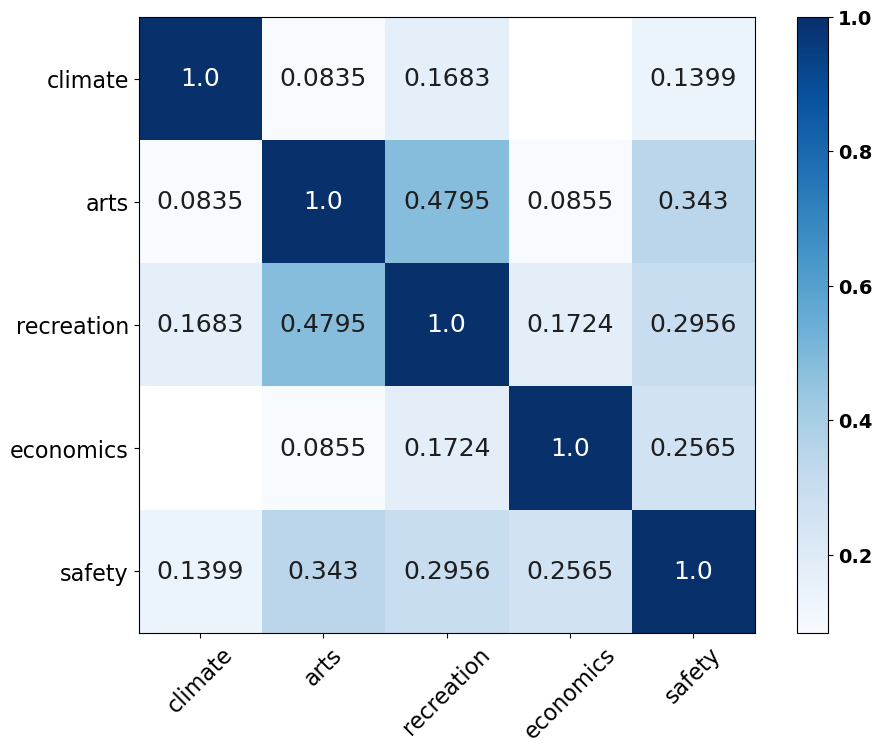

In [ ]:
#-----------------------------------------------------------------------------
# Function 1 - bn_rankcorr - Conditional rank correlation matrix
#-----------------------------------------------------------------------------

R = bn_rankcorr(parent_cell,        # structure of the BN
                data,               # matrix of data
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = True)           # create a plot (False = don't create plot)

# The plot shows that safety has the strongest correlation with arts,
# then the conditional correlation with recreation. The conditional 
# correlations with with economics and climate are weaker. Between other 
# variables, there is strong dependency between arts and recreation.


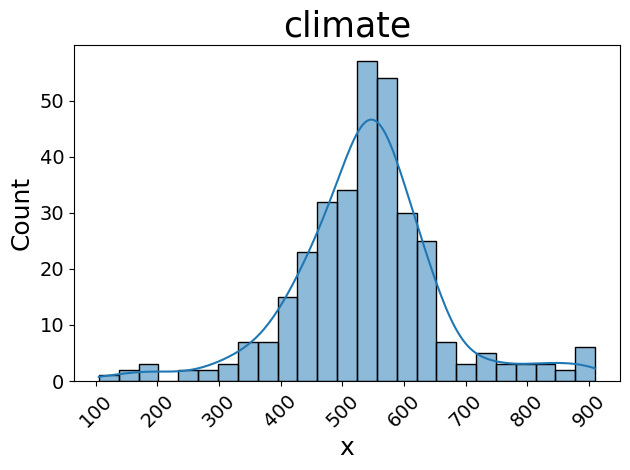

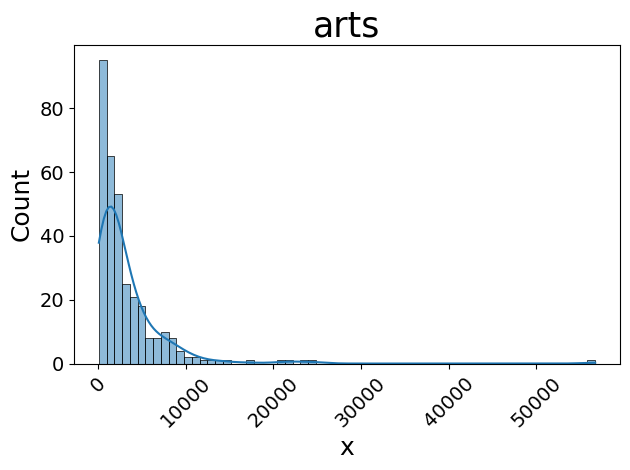

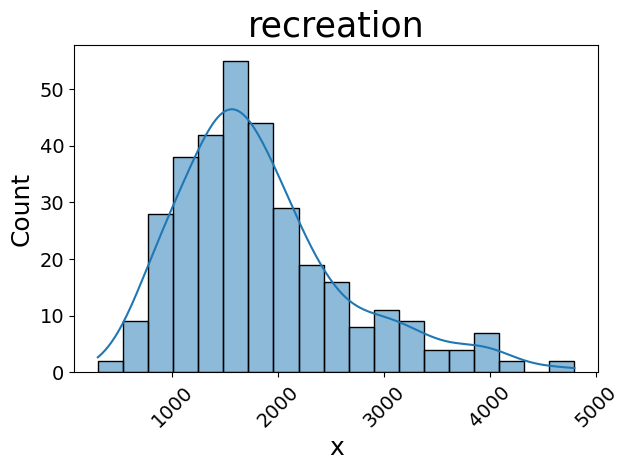

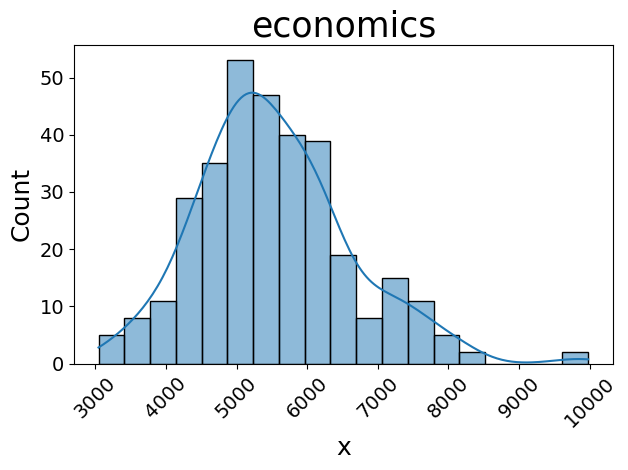

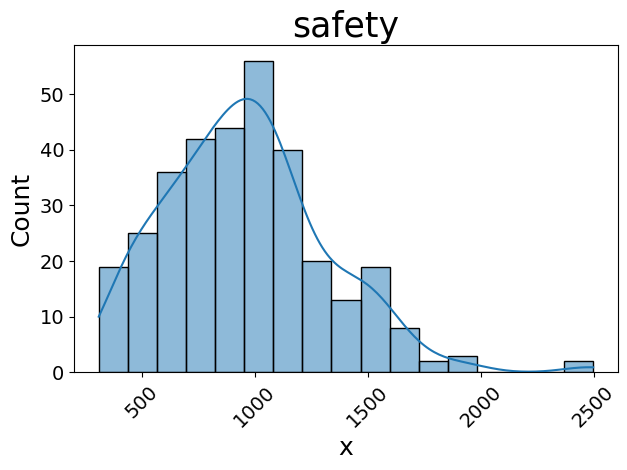

'BN plot saved in : c:\\Users\\Anna\\Documents\\UNI\\MA_topic\\flood-loss-models-4-HCMC\\models\\pybanshee_examples\\BN_visualize_bn_cities_margins.pdf'

In [ ]:
#-----------------------------------------------------------------------------
# Function 2 - bn_visualize - Plot of the Bayesian Network
#-----------------------------------------------------------------------------

bn_visualize(parent_cell,           # structure of the BN
             R,                     # the rank correlation matrix (function 1)
             data.columns,          # names of variables
             fig_name = fig_name)   # figure name
# The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# rank correlations indicated on the arcs.

bn_visualize(parent_cell,                       # structure of the BN
             R,                                 # the rank correlation matrix 
             data.columns,                      # names of variables
             data = data,                       # DataFrame with data
             fig_name = fig_name + '_margins')  # figure name
# The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# rank correlations indicated on the arcs. In this plot also the marginal
# distributions for each variable are incorporated.


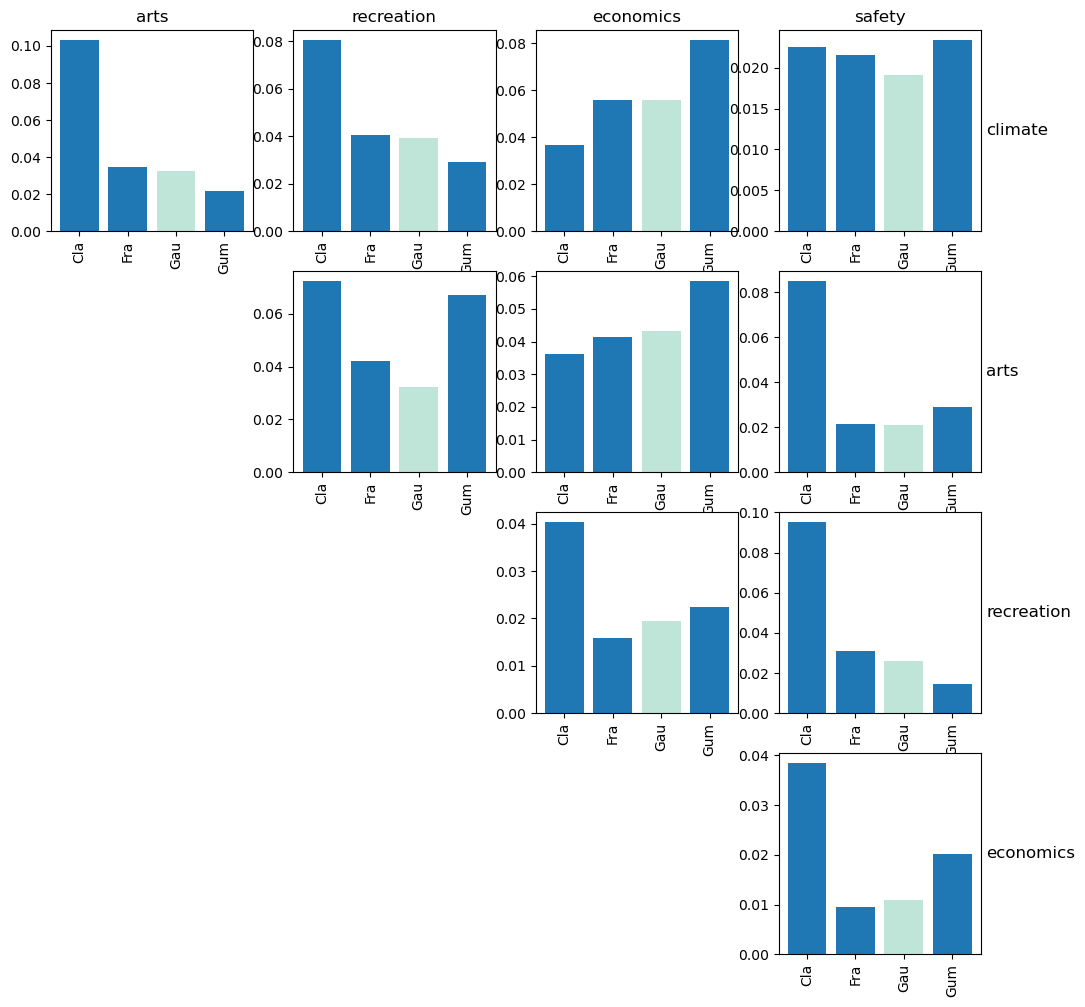

In [ ]:

#-----------------------------------------------------------------------------
# Function 3 - cvm_statistics - test goodness-of-fit of the Gaussian copula 
#-----------------------------------------------------------------------------

M = cvm_statistic(data,                   # DataFrame with data
                  names = data.columns,   # names of variables
                  plot = True,               # create a plot (0=don't create plot)
                  fig_name = fig_name)    # figure name
# The results of the goodness-of-fit test in terms of Cramer-von Mises
# statistic highlight that the Gaussian copula is in majority of cases the 
# most suitable for representing the dependency between variables, 
# especially for the variable of interest (safety). This is important as
# the method utilizes the Gaussian copula for dependence modelling.


In [ ]:
#-----------------------------------------------------------------------------
# Function 4 - gaussian_distance - measuring d-calibration score
#-----------------------------------------------------------------------------

## TODO fix np.mul() -> ~ np.matmul() in d_cal.py inside pybanshee package

# D_ERC,B_ERC,D_BNRC,B_BNRC = gaussian_distance(
#                             R,        # the rank correlation matrix 
#                             data,     # DataFrame with data
#                             4000,     # number of samples drawn d-Cal(ERC,NRC)
#                             400,      # number of samples drawn d-Cal(NRC,BNRC)
#                             1000,     # number of iterations to compute CI
#                             Plot=True,          # create a plot (0=don't create plot)
#                             Type='H',           # take Hellinger distance (default)
#                             fig_name=fig_name)  # figure name
# draw 4000 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (ERC,NRC)
# draw 400 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (NRC,BNRC)


# The d-calibration score of the empirical rank correlation matrix is
# inside the 90# confidence interval of the determinant of the empirical
# The d-calibration score of the BN's rank correlation matrix is well within  
# the 90# confidence interval of the determinant of the random normal distribution 
# sampled for the same correlation matrix. This supports the assumptions of
# a joint normal copula used in the BN model. It should be noted that the 
# test is sensitive to the number of samples drawn as well as the number of 
# iterations and is rather severe for large datasets.


In [ ]:
#-----------------------------------------------------------------------------
# Function 5 - inference - making inference with the BN model
#-----------------------------------------------------------------------------

condition=[0,1,2,3] #conditionalized variables, all except for safety (predict)
values = data.iloc[:,condition].to_numpy() # data for conditionalization

F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the
                                # nodes of the NPBN
              R,                # the rank correlation matrix 
              data,             # DataFrame with data
              Output='mean')    # type of output data


# Evaluation
y_pred = F.squeeze()

# Fill out the column(s) which are predicted
y_original=data.iloc[:,4].to_numpy()

# Calculate coefficient of determination
A = (y_pred - y_pred.mean(axis=0))/y_pred.std(axis=0)
B = (y_original - y_original.mean(axis=0))/y_original.std(axis=0)
correlation = (np.dot(B, A.T)/B.shape[0])
R2=correlation**2

# Calculate mean absolute error
MAE = np.mean(np.abs(y_pred-y_original))

# Calculate mean bias error
MBE = np.mean(y_pred-y_original)

# Calculate root mean square error
RMSE = (np.mean((y_pred-y_original)**2))**(1/2)

# The coefficient of determination between modelled and observed safety in 
# US cities is rather low (0.21), but the average error equals only around
# a quarter of the average value of safety, and there is almost no bias.
# However, for proper validation, if sufficient data is available, a split-
# -sample validation or a k-fold cross-validation should be performed.

Making inference. Progress:  0%
Making inference. Progress:  0%
Making inference. Progress:  0%
Making inference. Progress:  0%
Making inference. Progress:  1%
Making inference. Progress:  1%
Making inference. Progress:  1%
Making inference. Progress:  2%
Making inference. Progress:  2%
Making inference. Progress:  2%
Making inference. Progress:  3%
Making inference. Progress:  3%
Making inference. Progress:  3%
Making inference. Progress:  3%
Making inference. Progress:  4%
Making inference. Progress:  4%
Making inference. Progress:  4%
Making inference. Progress:  5%
Making inference. Progress:  5%
Making inference. Progress:  5%
Making inference. Progress:  6%
Making inference. Progress:  6%
Making inference. Progress:  6%
Making inference. Progress:  6%
Making inference. Progress:  7%
Making inference. Progress:  7%
Making inference. Progress:  7%
Making inference. Progress:  8%
Making inference. Progress:  8%
Making inference. Progress:  8%
Making inference. Progress:  9%
Making i